In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# 2017 Nicky van Foreest(vanforeest@gmail.com)                        #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################
#######################################################################
# Copyright (C)                                                       #
# 2017 Cheung Auyeung(cheung.auyeung@gmail.com)                       #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# actions: hit or stand
ACTION_HIT = 0
ACTION_STAND = 1  #  "strike" in the book
actions = [ACTION_HIT, ACTION_STAND]

In [4]:
# policy for player
policyPlayer = np.zeros(22)
for i in range(12, 20):
    policyPlayer[i] = ACTION_HIT
policyPlayer[20] = ACTION_STAND
policyPlayer[21] = ACTION_STAND

# function form of target policy of player
def targetPolicyPlayer(usableAcePlayer, playerSum, dealerCard):
    return policyPlayer[playerSum]

# function form of behavior policy of player
def behaviorPolicyPlayer(usableAcePlayer, playerSum, dealerCard):
    if np.random.binomial(1, 0.5) == 1:
        return ACTION_STAND
    return ACTION_HIT

In [5]:
# policy for dealer
policyDealer = np.zeros(22)
for i in range(12, 17):
    policyDealer[i] = ACTION_HIT
for i in range(17, 22):
    policyDealer[i] = ACTION_STAND

In [6]:
# get a new card
def getCard():
    card = np.random.randint(1, 14)
    card = min(card, 10)
    return card

In [7]:
# play a game
# @policyPlayerFn: specify policy for player
# @initialState: [whether player has a usable Ace, sum of player's cards, one card of dealer]
# @initialAction: the initial action
def play(policyPlayerFn, initialState=None, initialAction=None):
    # player status

    # sum of player
    playerSum = 0

    # trajectory of player
    playerTrajectory = []

    # whether player uses Ace as 11
    usableAcePlayer = False

    # dealer status
    dealerCard1 = 0
    dealerCard2 = 0
    usableAceDealer = False

    if initialState is None:
        # generate a random initial state

        numOfAce = 0

        # initialize cards of player
        while playerSum < 12:
            # if sum of player is less than 12, always hit
            card = getCard()

            # if get an Ace, use it as 11
            if card == 1:
                numOfAce += 1
                card = 11
                usableAcePlayer = True
            playerSum += card

        # if player's sum is larger than 21, he must hold at least one Ace, two Aces are possible
        if playerSum > 21:
            # use the Ace as 1 rather than 11
            playerSum -= 10

            # if the player only has one Ace, then he doesn't have usable Ace any more
            if numOfAce == 1:
                usableAcePlayer = False

        # initialize cards of dealer, suppose dealer will show the first card he gets
        dealerCard1 = getCard()
        dealerCard2 = getCard()

    else:
        # use specified initial state
        usableAcePlayer = initialState[0]
        playerSum = initialState[1]
        dealerCard1 = initialState[2]
        dealerCard2 = getCard()

    # initial state of the game
    state = [usableAcePlayer, playerSum, dealerCard1]

    # initialize dealer's sum
    dealerSum = 0
    if dealerCard1 == 1 and dealerCard2 != 1:
        dealerSum += 11 + dealerCard2
        usableAceDealer = True
    elif dealerCard1 != 1 and dealerCard2 == 1:
        dealerSum += dealerCard1 + 11
        usableAceDealer = True
    elif dealerCard1 == 1 and dealerCard2 == 1:
        dealerSum += 1 + 11
        usableAceDealer = True
    else:
        dealerSum += dealerCard1 + dealerCard2

    # game starts!

    # player's turn
    while True:
        if initialAction is not None:
            action = initialAction
            initialAction = None
        else:
            # get action based on current sum
            action = policyPlayerFn(usableAcePlayer, playerSum, dealerCard1)

        # track player's trajectory for importance sampling
        playerTrajectory.append([action, (usableAcePlayer, playerSum, dealerCard1)])

        if action == ACTION_STAND:
            break
        # if hit, get new card
        playerSum += getCard()

        # player busts
        if playerSum > 21:
            # if player has a usable Ace, use it as 1 to avoid busting and continue
            if usableAcePlayer == True:
                playerSum -= 10
                usableAcePlayer = False
            else:
                # otherwise player loses
                return state, -1, playerTrajectory

    # dealer's turn
    while True:
        # get action based on current sum
        action = policyDealer[dealerSum]
        if action == ACTION_STAND:
            break
        # if hit, get a new card
        dealerSum += getCard()
        # dealer busts
        if dealerSum > 21:
            if usableAceDealer == True:
            # if dealer has a usable Ace, use it as 1 to avoid busting and continue
                dealerSum -= 10
                usableAceDealer = False
            else:
            # otherwise dealer loses
                return state, 1, playerTrajectory

    # compare the sum between player and dealer
    if playerSum > dealerSum:
        return state, 1, playerTrajectory
    elif playerSum == dealerSum:
        return state, 0, playerTrajectory
    else:
        return state, -1, playerTrajectory

In [8]:
# Monte Carlo Sample with On-Policy
def monteCarloOnPolicy(nEpisodes):
    statesUsableAce = np.zeros((10, 10))
    # initialze counts to 1 to avoid 0 being divided
    statesUsableAceCount = np.ones((10, 10))
    statesNoUsableAce = np.zeros((10, 10))
    # initialze counts to 1 to avoid 0 being divided
    statesNoUsableAceCount = np.ones((10, 10))
    for i in range(0, nEpisodes):
        state, reward, _ = play(targetPolicyPlayer)
        state[1] -= 12
        state[2] -= 1
        if state[0]:
            statesUsableAceCount[state[1], state[2]] += 1
            statesUsableAce[state[1], state[2]] += reward
        else:
            statesNoUsableAceCount[state[1], state[2]] += 1
            statesNoUsableAce[state[1], state[2]] += reward
    return statesUsableAce / statesUsableAceCount, statesNoUsableAce / statesNoUsableAceCount

In [9]:
# print the state value
figureIndex = 0
def prettyPrint(data, tile, zlabel='reward'):
    global figureIndex
    fig = plt.figure(figureIndex)
    figureIndex += 1
    fig.suptitle(tile)
    ax = fig.add_subplot(111, projection='3d')
    axisX = []
    axisY = []
    axisZ = []
    for i in range(12, 22):
        for j in range(1, 11):
            axisX.append(i)
            axisY.append(j)
            axisZ.append(data[i - 12, j - 1])
    ax.scatter(axisX, axisY, axisZ)
    ax.set_xlabel('player sum')
    ax.set_ylabel('dealer showing')
    ax.set_zlabel(zlabel)

In [10]:
# Figure 5.1
def onPolicy():
    statesUsableAce1, statesNoUsableAce1 = monteCarloOnPolicy(10000)
    statesUsableAce2, statesNoUsableAce2 = monteCarloOnPolicy(500000)
    prettyPrint(statesUsableAce1, 'Usable Ace, 10000 Episodes')
    prettyPrint(statesNoUsableAce1, 'No Usable Ace, 10000 Episodes')
    prettyPrint(statesUsableAce2, 'Usable Ace, 500000 Episodes')
    prettyPrint(statesNoUsableAce2, 'No Usable Ace, 500000 Episodes')
    plt.show()

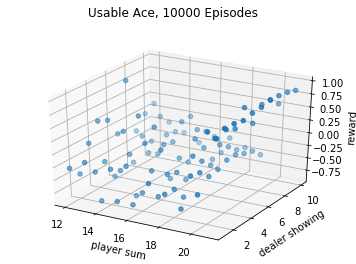

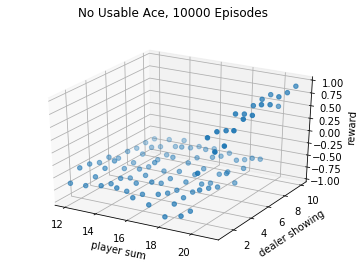

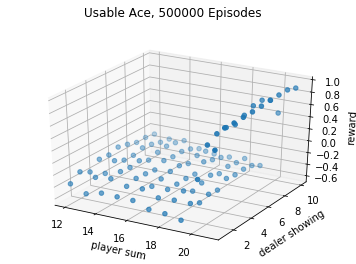

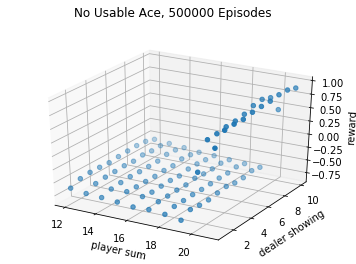

In [11]:
onPolicy()

In [12]:
# Monte Carlo with Exploring Starts
def monteCarloES(nEpisodes):
    # (playerSum, dealerCard, usableAce, action)
    stateActionValues = np.zeros((10, 10, 2, 2))
    # initialze counts to 1 to avoid division by 0
    stateActionPairCount = np.ones((10, 10, 2, 2))

    # behavior policy is greedy
    def behaviorPolicy(usableAce, playerSum, dealerCard):
        usableAce = int(usableAce)
        playerSum -= 12
        dealerCard -= 1
        # get argmax of the average returns(s, a)
        return np.argmax(stateActionValues[playerSum, dealerCard, usableAce, :]
                      / stateActionPairCount[playerSum, dealerCard, usableAce, :])

    # play for several episodes
    for episode in range(nEpisodes):
        if episode % 1000 == 0:
            print('episode:', episode)
        # for each episode, use a randomly initialized state and action
        initialState = [bool(np.random.choice([0, 1])),
                       np.random.choice(range(12, 22)),
                       np.random.choice(range(1, 11))]
        initialAction = np.random.choice(actions)
        _, reward, trajectory = play(behaviorPolicy, initialState, initialAction)
        for action, (usableAce, playerSum, dealerCard) in trajectory:
            usableAce = int(usableAce)
            playerSum -= 12
            dealerCard -= 1
            # update values of state-action pairs
            stateActionValues[playerSum, dealerCard, usableAce, action] += reward
            stateActionPairCount[playerSum, dealerCard, usableAce, action] += 1

    return stateActionValues / stateActionPairCount

In [13]:
# Figure 5.3
def figure5_3():
    stateActionValues = monteCarloES(500000)
    stateValueUsableAce = np.zeros((10, 10))
    stateValueNoUsableAce = np.zeros((10, 10))
    # get the optimal policy
    actionUsableAce = np.zeros((10, 10), dtype='int')
    actionNoUsableAce = np.zeros((10, 10), dtype='int')
    for i in range(10):
        for j in range(10):
            stateValueNoUsableAce[i, j] = np.max(stateActionValues[i, j, 0, :])
            stateValueUsableAce[i, j] = np.max(stateActionValues[i, j, 1, :])
            actionNoUsableAce[i, j] = np.argmax(stateActionValues[i, j, 0, :])
            actionUsableAce[i, j] = np.argmax(stateActionValues[i, j, 1, :])
    prettyPrint(stateValueUsableAce, 'Optimal state value with usable Ace')
    prettyPrint(stateValueNoUsableAce, 'Optimal state value with no usable Ace')
    prettyPrint(actionUsableAce, 'Optimal policy with usable Ace', 'Action (0 Hit, 1 Stick)')
    prettyPrint(actionNoUsableAce, 'Optimal policy with no usable Ace', 'Action (0 Hit, 1 Stick)')
    plt.show()

episode: 0
episode: 1000
episode: 2000
episode: 3000
episode: 4000
episode: 5000
episode: 6000
episode: 7000
episode: 8000
episode: 9000
episode: 10000
episode: 11000
episode: 12000
episode: 13000
episode: 14000
episode: 15000
episode: 16000
episode: 17000
episode: 18000
episode: 19000
episode: 20000
episode: 21000
episode: 22000
episode: 23000
episode: 24000
episode: 25000
episode: 26000
episode: 27000
episode: 28000
episode: 29000
episode: 30000
episode: 31000
episode: 32000
episode: 33000
episode: 34000
episode: 35000
episode: 36000
episode: 37000
episode: 38000
episode: 39000
episode: 40000
episode: 41000
episode: 42000
episode: 43000
episode: 44000
episode: 45000
episode: 46000
episode: 47000
episode: 48000
episode: 49000
episode: 50000
episode: 51000
episode: 52000
episode: 53000
episode: 54000
episode: 55000
episode: 56000
episode: 57000
episode: 58000
episode: 59000
episode: 60000
episode: 61000
episode: 62000
episode: 63000
episode: 64000
episode: 65000
episode: 66000
episode:

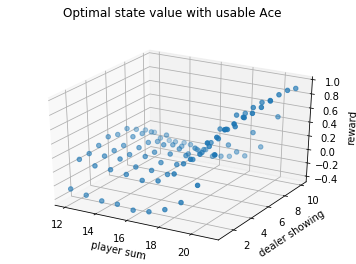

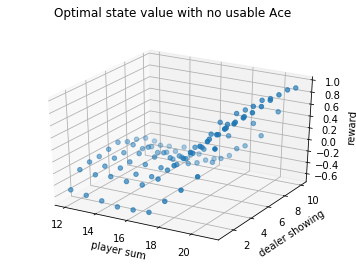

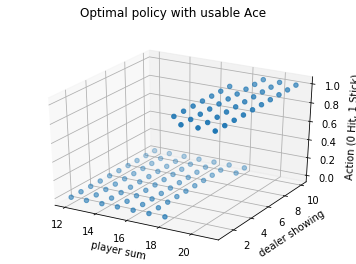

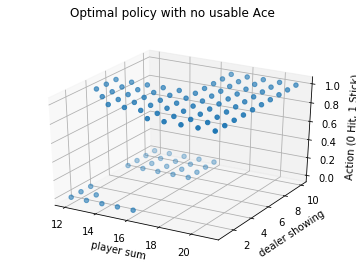

In [14]:
figure5_3()

In [15]:
# Monte Carlo Sample with Off-Policy
def monteCarloOffPolicy(nEpisodes):
    initialState = [True, 13, 2]
    sumOfImportanceRatio = [0]
    sumOfRewards = [0]
    for i in range(0, nEpisodes):
        _, reward, playerTrajectory = play(behaviorPolicyPlayer, initialState=initialState)

        # get the importance ratio
        importanceRatioAbove = 1.0
        importanceRatioBelow = 1.0
        for action, (usableAce, playerSum, dealerCard) in playerTrajectory:
            if action == targetPolicyPlayer(usableAce, playerSum, dealerCard):
                importanceRatioBelow *= 0.5
            else:
                importanceRatioAbove = 0.0
                break
        importanceRatio = importanceRatioAbove / importanceRatioBelow
        sumOfImportanceRatio.append(sumOfImportanceRatio[-1] + importanceRatio)
        sumOfRewards.append(sumOfRewards[-1] + reward * importanceRatio)
    del sumOfImportanceRatio[0]
    del sumOfRewards[0]

    sumOfRewards= np.asarray(sumOfRewards)
    sumOfImportanceRatio= np.asarray(sumOfImportanceRatio)
    ordinarySampling = sumOfRewards / np.arange(1, nEpisodes + 1)

    with np.errstate(divide='ignore',invalid='ignore'):
        weightedSampling = np.where(sumOfImportanceRatio != 0, sumOfRewards / sumOfImportanceRatio, 0)

    return ordinarySampling, weightedSampling

In [16]:
# Figure 5.4
def offPolicy():
    trueValue = -0.27726
    nEpisodes = 10000
    nRuns = 100
    ordinarySampling = np.zeros(nEpisodes)
    weightedSampling = np.zeros(nEpisodes)
    for i in range(0, nRuns):
        ordinarySampling_, weightedSampling_ = monteCarloOffPolicy(nEpisodes)
        # get the squared error
        ordinarySampling += np.power(ordinarySampling_ - trueValue, 2)
        weightedSampling += np.power(weightedSampling_ - trueValue, 2)
    ordinarySampling /= nRuns
    weightedSampling /= nRuns
    axisX = np.log10(np.arange(1, nEpisodes + 1))
    plt.plot(axisX, ordinarySampling, label='Ordinary Importance Sampling')
    plt.plot(axisX, weightedSampling, label='Weighted Importance Sampling')
    plt.xlabel('Episodes (10^x)')
    plt.ylabel('Mean square error')
    plt.legend()
    plt.show()

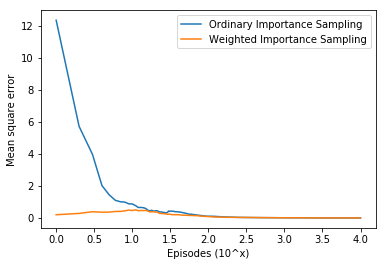

In [17]:
offPolicy()